In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import sbi
import torch

In [2]:
def simulate_PA(params):
    v,a = params
    dt = 1e-3; dB = np.sqrt(dt)
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t, 1, (v,a)
        elif DV <= -a:
            return t, 0, (v,a)

In [3]:
v = 1; a = 1

In [4]:
from joblib import Parallel, delayed

In [5]:
N_sim = int(1e5)

In [6]:
# v prior from 0.1 to 3
# a prior from 0.1 to 3
# N_sim pairs
import numpy as np
v_distr = np.random.uniform(0.1, 3, N_sim)
a_distr = np.random.uniform(0.1, 3, N_sim)

params_np = np.array([v_distr,a_distr]).T

In [7]:
params_np.shape

(100000, 2)

In [8]:
sim_results = Parallel(n_jobs=-1)(delayed(simulate_PA)([params_np[i,0], params_np[i,1]]) for i in range(N_sim))

In [9]:
rt_np_arr = np.array([sim_results[i][0] for i in range(N_sim)])
choice_np_arr = np.array([sim_results[i][1] for i in range(N_sim)])
theta_tuple = np.array([sim_results[i][2] for i in range(N_sim)])


In [10]:
rt_np_arr.shape, choice_np_arr.shape, theta_tuple.shape

((100000,), (100000,), (100000, 2))

In [11]:
import torch
theta_tensor = torch.tensor(theta_tuple, dtype=torch.float32)
theta_tensor.shape

torch.Size([100000, 2])

In [12]:
# x tensor - rt, choice side by side
x_tensor = torch.tensor(np.array([rt_np_arr, choice_np_arr]).T, dtype=torch.float32)
x_tensor.shape

torch.Size([100000, 2])

In [13]:
from torch.distributions import Uniform
v_distr = Uniform(torch.tensor([0.1]), torch.tensor([3]))    # decision boundary
a_distr = Uniform(torch.tensor([0.1]), torch.tensor([3]))    # decision boundary
from sbi.utils import MultipleIndependent

prior = MultipleIndependent(
    [
        v_distr,
        a_distr
    ]
)

2024-11-30 16:02:25.446034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 16:02:25.455158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 16:02:25.463898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 16:02:25.466593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 16:02:25.474544: I tensorflow/core/platform/cpu_feature_guar

In [14]:
from sbi.inference import MNLE

trainer = MNLE(prior = prior)
x_tensor[:, 1] = x_tensor[:, 1].to(dtype=torch.int64)  # Ensure it's categorical
print(torch.unique(x_tensor[:, 1]))
print(f"x_tensor[:, 0].dtype = {x_tensor[:, 0].dtype}, x_tensor[:, 1].dtype = {x_tensor[:, 1].dtype}")


tensor([0., 1.])
x_tensor[:, 0].dtype = torch.float32, x_tensor[:, 1].dtype = torch.float32


In [ ]:
print(f' theta_tensor.shape = {theta_tensor.shape} \n x_tensor.shape = {x_tensor.shape}, prior = {prior}')
trainer = MNLE(prior = prior)
trainer_1 = trainer.append_simulations(theta=theta_tensor,x= x_tensor).train()

 theta_tensor.shape = torch.Size([100000, 2]) 
 x_tensor.shape = torch.Size([100000, 2]), prior = MultipleIndependent()


/home/rka/code/ddm_codes/venv/lib/python3.10/site-packages/sbi/neural_nets/factory.py:205: UserWarning: The mixed neural likelihood estimator assumes that x contains continuous data in the first n-1 columns (e.g., reaction times) and categorical data in the last column (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return model_builders[model](batch_x=batch_x, batch_y=batch_theta, **kwargs)


 Neural network successfully converged after 73 epochs.

In [16]:
v,a

(1, 1)

In [17]:
test_sim_data = Parallel(n_jobs=-1)(delayed(simulate_PA)([v,a]) for _ in range(N_sim))

In [20]:
test_sim_rt = np.array([test_sim_data[i][0] for i in range(N_sim)])
test_sim_choice = np.array([test_sim_data[i][1] for i in range(N_sim)])
test_sim_theta = np.array([test_sim_data[i][2] for i in range(N_sim)])


In [22]:
test_sim_choice_0_idx = np.where(test_sim_choice == 0)
test_sim_choice_0_idx

(array([    6,    11,    12, ..., 99954, 99975, 99997]),)

In [23]:
# multiple test_sim_choice_0_idx by -1 in test_sim_rt
test_sim_rt[test_sim_choice_0_idx] *= -1

test_sim_rt.shape

(100000,)

In [24]:
test_sim_theta.shape

(100000, 2)

In [25]:
test_sim_theta_tensor = torch.tensor(test_sim_theta, dtype=torch.float32)
test_sim_theta_tensor.shape, test_sim_theta_tensor.dtype

(torch.Size([100000, 2]), torch.float32)

In [27]:
test_sim_x_tensor = torch.tensor(np.array([test_sim_rt, test_sim_choice]).T, dtype=torch.float32)
test_sim_x_tensor.shape, test_sim_x_tensor.dtype

(torch.Size([100000, 2]), torch.float32)

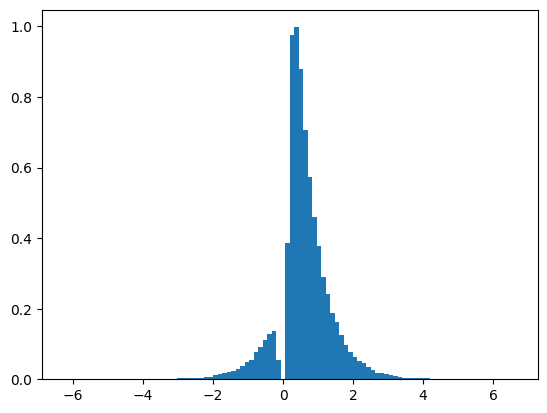

In [30]:
plt.hist(test_sim_rt, bins=100, density=True);
plt.hist


In [33]:
test_sim_theta.shape

(100000, 2)

In [37]:
test_sim_theta[0]

array([1, 1])

In [39]:
torch.Size(test_sim_theta_tensor)

TypeError: 'int' object is not iterable

In [65]:
from inspect import getsource
print(getsource(trainer_1.log_prob))


    def log_prob(self, input: Tensor, condition: Tensor) -> Tensor:
        r"""Return the log probabilities of the inputs given a condition or multiple
        i.e. batched conditions.


        Args:
            input: Inputs to evaluate the log probability on. Of shape
                `(sample_dim, batch_dim, *event_shape)`.
            condition: Conditions of shape `(batch_dim, *event_shape)`.

        Raises:
            NotImplementedError: If `input` has a sample shape > 1. The reason
                is that in MLE, discrete and continuous data are combined into one
                condition, creating a mismatch if sample shapes are present because
                the condition cannot have a sample shape.
            AssertionError: If `input_batch_dim != condition_batch_dim`.

        Returns:
            Sample-wise log probabilities, shape `(input_sample_dim, input_batch_dim)`.
        """

        assert (
            input.dim() > 2
        ), "Input must be of shape (samp

In [53]:
torch.Size([1, 2])

torch.Size([1, 2])

In [54]:
x_syn = trainer_1.sample([N_sim, 2], N_sim)

AttributeError: 'int' object has no attribute 'shape'

In [55]:
test_sim_theta_tensor.shape, test_sim_x_tensor.shape

(torch.Size([100000, 2]), torch.Size([100000, 2]))

In [60]:
test_sim_x_tensor.reshape(-1,1,2).shape, test_sim_theta_tensor.shape

(torch.Size([100000, 1, 2]), torch.Size([100000, 2]))

In [67]:

# apply abs on 1st column of test_sim_x_tensor
test_sim_x_tensor[:,0] = torch.abs(test_sim_x_tensor[:,0])

In [74]:
test_data = torch.linspace(-8, 8, 1000)
# Separate rts and choices.
test_rts = abs(test_data)
test_cs = torch.ones_like(test_data)
test_cs[test_data < 0] = 0
test_x = torch.stack((test_rts, test_cs), dim=1)

# Get the log likelihood of the entire range of reaction times and choices.
print(f"test_x.shape = {test_x.shape}, test_sim_theta_tensor.shape = {test_sim_theta_tensor[:1000,:].shape}")
mnle_likelihoods = trainer_1.log_prob(test_x.reshape(1,-1,2), test_sim_theta_tensor[:1000,:]).detach()

test_x.shape = torch.Size([1000, 2]), test_sim_theta_tensor.shape = torch.Size([1000, 2])


In [68]:
print(test_sim_x_tensor.shape, test_sim_theta_tensor.shape)
mnle_loglike = trainer_1.log_prob( test_sim_x_tensor.reshape(1, -1,2), test_sim_theta_tensor)

torch.Size([100000, 2]) torch.Size([100000, 2])


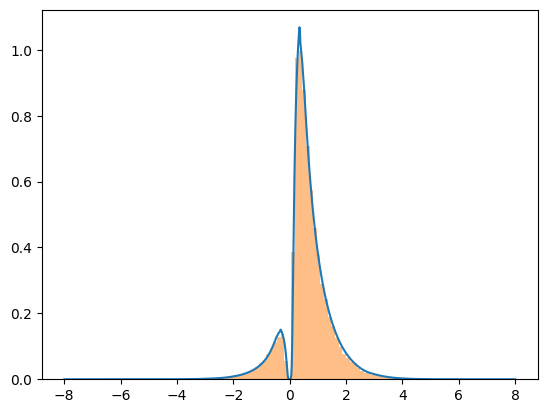

In [80]:
plt.plot(
    test_data, mnle_likelihoods.exp().squeeze(), label="MNLE likelihood", ls="-",
)

plt.hist(test_sim_rt, bins=100, density=True, alpha=0.5, label="simulated data");